# Translation from One Language to Another

This model will appear on my HuggingFace profile as: 'mbart-large-50-English_German_Translation'
    
Dataset Source: https://www.kaggle.com/datasets/hgultekin/paralel-translation-corpus-in-22-languages

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import DataCollatorForSeq2Seq, MBart50Tokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Software & Libraries Used

In [2]:
print("Transformers:".rjust(15), transformers.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Python:".rjust(15), sys.version[0:6]) 
print("Datasets:".rjust(15), datasets.__version__)

  Transformers: 4.22.2
        Pandas: 1.5.0
         NumPy: 1.23.3
        Python: 3.9.12
      Datasets: 2.5.2


#### Ingest & Start Preprocessing Data

In [3]:
data = pd.read_csv('~/Documents/nlpnn/Datasets/Translations/EN-ES (Spanish)/EN-ES.txt', 
                   delimiter='\t', 
                   engine="c", 
                   header=None)

data.drop_duplicates(inplace=True)

data.dropna(inplace=True)

data[0] = data[0].str.strip()
data[1] = data[1].str.strip()

data.drop(columns=[2, 3, 4, 5, 6, 7], inplace=True)

data.rename(columns={1 : 'spanish', 0 : 'english'}, inplace=True)

data = data[~data['english'].str.contains('\\d', regex=True)] # Drop samples with numbers

data.reset_index(inplace=True, drop=True)

data

,english,spanish
0,"THE COMMISSION OF THE EUROPEAN COMMUNITIES,","LA COMISIÓN DE LAS COMUNIDADES EUROPEAS,"
1,Having regard to the Treaty establishing the E...,Visto el Tratado constitutivo de la Comunidad ...
2,Whereas:,Considerando lo siguiente:
3,The amount(s) of the processing securities mus...,El o los importes de las garantías de transfor...
4,The measures provided for in this Regulation a...,Las medidas previstas en el presente Reglament...
...,...,...
3316272,For the Commission,Por la Comisión
3316273,Agriculture Director-General,Director General de Agricultura
3316274,ANNEX,ANEXO
3316275,CN code,Código NC


#### Visual: Length of English Entries

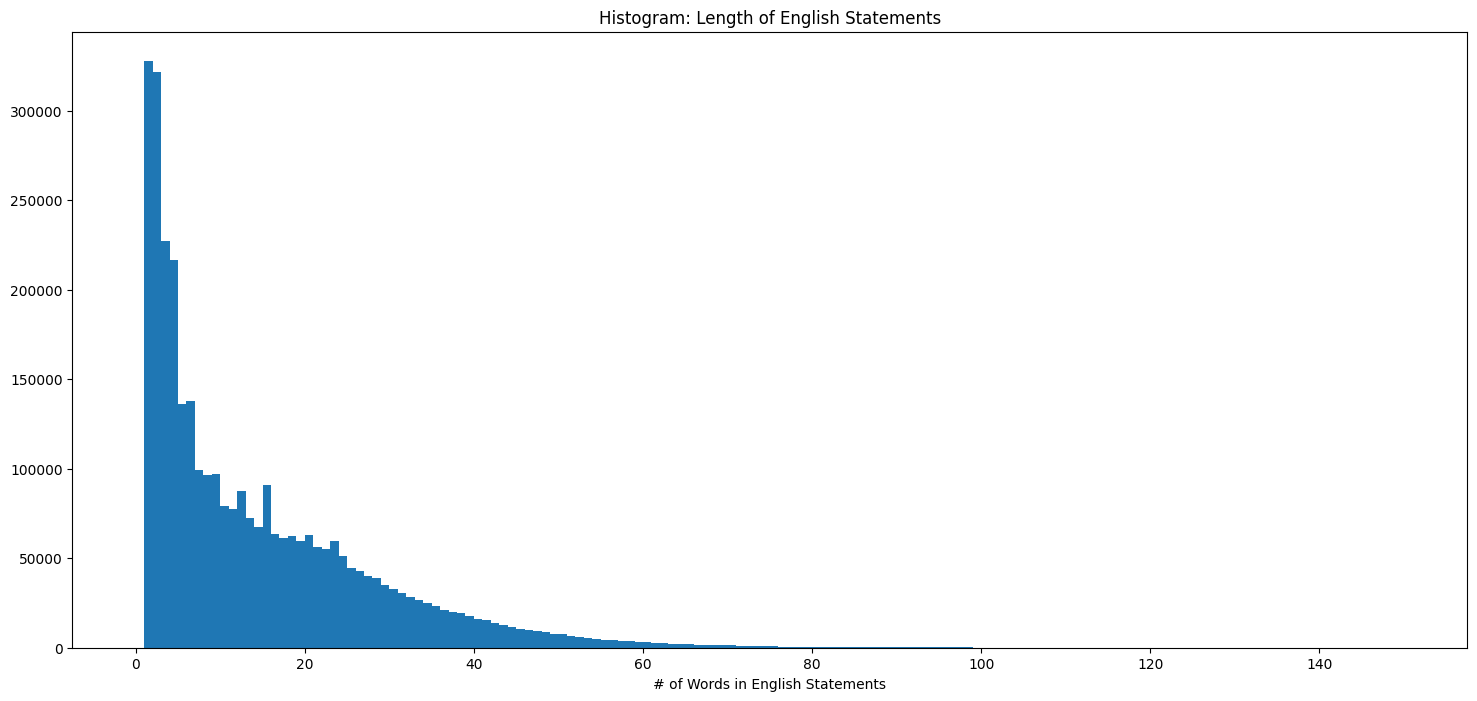

The maximum length of English text (in words) is 291 words.


In [4]:
data['english_length'] = data['english'].str.split().str.len()

n_bin = 150
data.hist('english_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.show()

print(f"The maximum length of English text (in words) is {max(data['english_length'])} words.")

#### Visual: Length of Spanish Entries

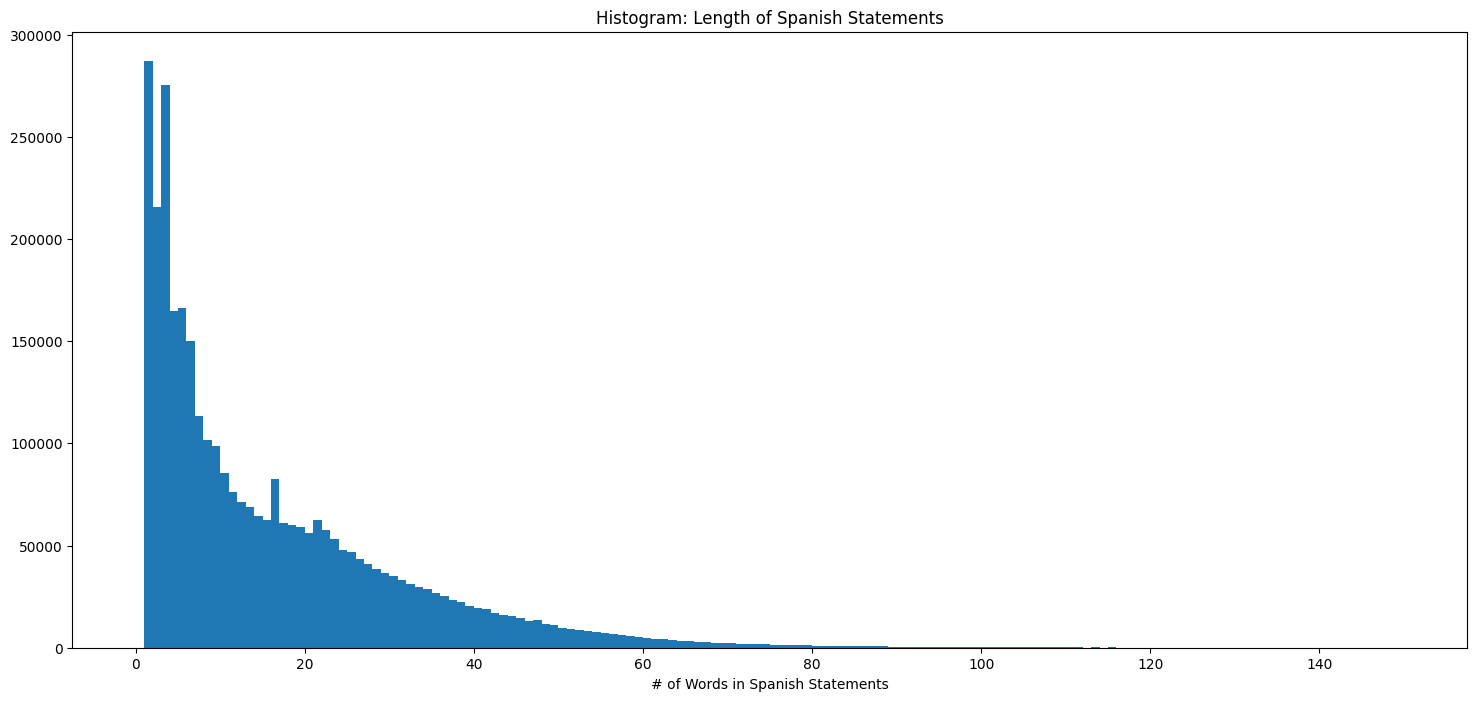

The maximum length of Spanish text (in words) is 330 words.


In [5]:
data['spanish_length'] = data['spanish'].str.split().str.len()

n_bin=150
data.hist('spanish_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Spanish Statements')
plt.xlabel('# of Words in Spanish Statements')
plt.show()

print(f"The maximum length of Spanish text (in words) is {max(data['spanish_length'])} words.")

#### Trim Dataset Size & Drop Unnecessary Features

In [6]:
upper_limit = 46
lower_limit = 5

data = data[data['spanish_length'] < upper_limit] # make sure that the Spanish text ..
data = data[data['spanish_length'] > lower_limit] # has between 6 & 45 words

data = data[data['english_length'] < upper_limit] # make sure that the English text ..
data = data[data['english_length'] > lower_limit] # has between 6 & 45 words

data.reset_index(drop=True, inplace=True)

data['eng_char_length'] = data['english'].str.len() # add column with calculated character length
data['spanish_char_length'] = data['spanish'].str.len() # add column with calculated character length

data = data[data['eng_char_length'] > 30] # make sure that the text has over 30 characters...
data = data[data['spanish_char_length'] > 30] # ... for both languages

# reset the index
data.reset_index(drop=True, inplace=True)

# Remove columns that are no longer necessary
data.drop(columns=['spanish_length', 
                   'english_length', 
                   'eng_char_length', 
                   'spanish_char_length'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855652 entries, 0 to 1855651
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   english  object
 1   spanish  object
dtypes: object(2)
memory usage: 28.3+ MB


#### Randomly Sample 36,000 Samples (Due to Hardware Limitations)

In [7]:
data = data.sample(n=36000, random_state=42, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  36000 non-null  object
 1   spanish  36000 non-null  object
dtypes: object(2)
memory usage: 562.6+ KB


#### Final Preprocessing

In [8]:
data.rename(columns={'english' : 'en', 'spanish' : 'es'}, inplace=True)

all_data = data.to_dict(orient='records')
df = pd.Series(all_data)
df = pd.DataFrame(df)
df.rename(columns={ 0 : 'translation'}, inplace=True)
df.head()

,translation
0,{'en': 'or [has been vaccinated against Newcas...
1,{'en': 'Annex XX to the Agreement shall be ame...
2,{'en': 'Selling ABX is considered a positive s...
3,"{'en': 'For the abovementioned reasons, the Ic..."
4,{'en': 'the definition of the requirements con...


#### Convert to Dataset Format & Split into Train/Test/Eval Datasets

In [9]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (28800, 1)
Testing Dataset Shape: (3600, 1)
Evaluation Dataset Shape: (3600, 1)


{'translation': {'en': 'However, it should be noted whether the BAF is based on steady state concentrations or not.',
  'es': 'Sin embargo, ha de señalarse si el BAF se basa o no en las concentraciones en el estado estable.'}}

#### Remember to Install git lfs & Enter HuggingFace Access Token

In [10]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


#### Basic Values/Constants

In [11]:
set_seed = 42
NUM_OF_EPOCHS = 2

BATCH_SIZE = 32
LEARNING_RATE = 2e-5

SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "es"

MAX_LENGTH = int(upper_limit*2)
MODEL_CKPT = "facebook/mbart-large-50"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cpu


#### Create Tokenizer

In [12]:
tokenizer = MBart50Tokenizer.from_pretrained(MODEL_CKPT, num_labels=2)

if "mbart" in MODEL_CKPT:
    tokenizer.src_lang="en_XX"
    tokenizer.tgt_lang='es_XX'

#### Create Preprocessing Function

In [13]:
def tokenizing_function(examples):
    inputs = [ex[SOURCE_LANGUAGE] for ex in examples['translation']]
    targets = [ex[TARGET_LANGUAGE] for ex in examples['translation']]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=MAX_LENGTH, truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [14]:
encoded_ds = ds.map(tokenizing_function, batched=True, load_from_cache_file=False)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Print Example to Make Sure Edits Work as Expected

In [15]:
print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

(28800, 4)
(3600, 4)
(3600, 4)


#### Instantiate Model

In [16]:
model = (AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT, num_labels=2)).to(DEVICE)

#### Instantiate Data Collator

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

#### Create Function to Compute Metrics

In [18]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    
    bleu_results = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_results = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {"bleu" : bleu_results["score"], "rouge" : rouge_results, "meteor" : meteor_results}

A Jupyter Widget

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/briandunn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Instantiate Training Arguments

In [19]:
MODEL_NAME = MODEL_CKPT.split("/")[-1]
MODEL_NAME = f"{MODEL_NAME}-English_Spanish_Translation"

args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME, 
                                per_device_train_batch_size=BATCH_SIZE, 
                                per_device_eval_batch_size=BATCH_SIZE,
                                evaluation_strategy="epoch", 
                                logging_strategy="epoch", 
                                learning_rate=LEARNING_RATE,
                                report_to='all', 
                                weight_decay=0.01, 
                                save_total_limit=2, 
                                disable_tqdm=False,
                                num_train_epochs=NUM_OF_EPOCHS, 
                                predict_with_generate=True,
                                push_to_hub=True)

#### Instantiate Trainer

In [20]:
trainer = Seq2SeqTrainer(model=model, 
                         args=args, 
                         train_dataset=encoded_ds['train'], 
                         eval_dataset=encoded_ds['eval'], 
                         tokenizer=tokenizer, 
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/huggingface_hub/repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/mbart-large-50-English_Spanish_Translation into local empty directory.


#### Train Model

In [21]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1800


A Jupyter Widget

Saving model checkpoint to mbart-large-50-English_Spanish_Translation/checkpoint-500
Configuration saved in mbart-large-50-English_Spanish_Translation/checkpoint-500/config.json
Model weights saved in mbart-large-50-English_Spanish_Translation/checkpoint-500/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_Spanish_Translation/checkpoint-500/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_Spanish_Translation/checkpoint-500/special_tokens_map.json
tokenizer config file saved in mbart-large-50-English_Spanish_Translation/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_Spanish_Translation/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num 

{'loss': 1.5608, 'learning_rate': 1e-05, 'epoch': 1.0}


A Jupyter Widget

{'eval_loss': 1.0898619890213013, 'eval_bleu': 39.918446357659285, 'eval_rouge': {'rouge1': 0.6645461901016299, 'rouge2': 0.48457734138815345, 'rougeL': 0.6254335531454508, 'rougeLsum': 0.6258737583448748}, 'eval_meteor': {'meteor': 0.6376166612731494}, 'eval_runtime': 41632.9691, 'eval_samples_per_second': 0.086, 'eval_steps_per_second': 0.003, 'epoch': 1.0}


Saving model checkpoint to mbart-large-50-English_Spanish_Translation/checkpoint-1000
Configuration saved in mbart-large-50-English_Spanish_Translation/checkpoint-1000/config.json
Model weights saved in mbart-large-50-English_Spanish_Translation/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_Spanish_Translation/checkpoint-1000/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_Spanish_Translation/checkpoint-1000/special_tokens_map.json
tokenizer config file saved in mbart-large-50-English_Spanish_Translation/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_Spanish_Translation/special_tokens_map.json
Saving model checkpoint to mbart-large-50-English_Spanish_Translation/checkpoint-1500
Configuration saved in mbart-large-50-English_Spanish_Translation/checkpoint-1500/config.json
Model weights saved in mbart-large-50-English_Spanish_Translation/checkpoint-1500/pytorch_model.bin
tokenizer config file sa

{'loss': 0.9734, 'learning_rate': 0.0, 'epoch': 2.0}


A Jupyter Widget



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.0289689302444458, 'eval_bleu': 41.44356165831565, 'eval_rouge': {'rouge1': 0.6751348620702116, 'rouge2': 0.4976855704059807, 'rougeL': 0.6371345376462452, 'rougeLsum': 0.6376186633843448}, 'eval_meteor': {'meteor': 0.6479188510808377}, 'eval_runtime': 40918.351, 'eval_samples_per_second': 0.088, 'eval_steps_per_second': 0.003, 'epoch': 2.0}
{'train_runtime': 455127.531, 'train_samples_per_second': 0.127, 'train_steps_per_second': 0.004, 'train_loss': 1.2670740763346353, 'epoch': 2.0}


TrainOutput(global_step=1800, training_loss=1.2670740763346353, metrics={'train_runtime': 455127.531, 'train_samples_per_second': 0.127, 'train_steps_per_second': 0.004, 'train_loss': 1.2670740763346353, 'epoch': 2.0})

#### Evaluate Model

In [22]:
trainer.evaluate(max_length=MAX_LENGTH)

The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3600
  Batch size = 32


A Jupyter Widget

{'eval_loss': 1.0289689302444458,
 'eval_bleu': 41.443724393304315,
 'eval_rouge': {'rouge1': 0.6751402780531002,
  'rouge2': 0.49769602014143044,
  'rougeL': 0.6371513427059108,
  'rougeLsum': 0.6376403149816605},
 'eval_meteor': {'meteor': 0.6479226630466496},
 'eval_runtime': 40243.222,
 'eval_samples_per_second': 0.089,
 'eval_steps_per_second': 0.003,
 'epoch': 2.0}

#### Push Model to HuggingFace Hub (My Profile!)

In [24]:
trainer.push_to_hub(tags="translation")

Saving model checkpoint to mbart-large-50-English_Spanish_Translation
Configuration saved in mbart-large-50-English_Spanish_Translation/config.json
Model weights saved in mbart-large-50-English_Spanish_Translation/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_Spanish_Translation/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_Spanish_Translation/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Bleu', 'type': 'bleu', 'value': 41.443724393304315}, {'name': 'Rouge', 'type': 'rouge', 'value': {'rouge1': 0.6751402780531002, 'rouge2': 0.49769602014143044, 'rougeL': 0.6371513427059108, 'rougeLsum': 0.6376403149816605}}]}
To https://huggingface.co/DunnBC22/mbart-large-50-English_Spanish_Translation
   c34dbf3..16e1c56  main -> main

   c34dbf3..16e1c56  main -> main



### Notes & Other Takeaways From This Project
****
- The results are pretty good!
****
- While the results improved from the first to the second epoch, I will not use a second epoch when I train the next machine translation project or two. It would be beneficial to train a machine learning project for 3, maybe even 4, epochs; however, for the intent here (personal project to demonstrate skillset), I am going to stick to a single epoch.
****